In [330]:
import wandb
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [331]:
api = wandb.Api()

In [332]:
SAVE_DIR = "/Users/pari/Desktop/"
#/Users/pari/Desktop

In [333]:
pgruns = api.runs("pari/MyCEB",
    {"$and": [
       {"config.algs": "postgres"},
       {"config.val_size":0},
       {"config.test_size":0},
       {"config.query_templates":"all"},
       {"config.query_dir":"queries/imdb-unique-plans"},
       {"config.num_samples_per_template":-1},
       {"$or": [
           {"tags":"v14"},
       ]}
    ]
    })

print(f"Found {len(pgruns)} runs")

Found 5 runs


In [334]:
import time
start = time.time()
#summary_list, config_list, name_list = [], [], []
#TAGS = ["baselines", "baseline", "best_model_0.2", "best_model"]
pgdfs = []

for run in pgruns:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    pgdfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)

took:  0.03252696990966797


In [335]:
pgdf = pd.concat(pgdfs)

In [336]:
pgdf

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-Relative-TotalPPCost-train-3b,Final-Relative-TotalPPCost-train-9b,Final-Relative-TotalPPCost-train-C2-11b,Final-Relative-TotalPPCost-train-C2-9a,Final-Relative-TotalPPCost-train-C2-9b,Final-Relative-TotalPPCost-train-C2-11a,Final-Relative-TotalPPCost-train-C2-3b,Final-Relative-TotalPPCost-train-10a,Final-Relative-TotalPPCost-train-11b,Final-Relative-TotalPPCost-train-C2-10a
0,[v14],helpful-voice-5981,0.0001,password,postgres,5431,123,ceb,0.005,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,[v14],desert-breeze-5979,0.0001,password,postgres,5431,123,ceb,0.005,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,[v14],lemon-silence-5972,0.0001,password,postgres,5431,123,ceb,0.005,0,...,1.378,2.009,2.749,2.315,14.081,1.859,404.804,2.979,2.059,2.26


In [337]:
#pgdf = pgdf[~pgdf["Final-Relative-TotalPPCost-train-2a"].isna()]

In [338]:
runs = api.runs("pari/MyCEB",
    {"$and": [
       {"config.algs": "mscn"},
       {"config.train_test_split_kind":"custom"},
       {"config.test_tmps":"all"},
       {"config.query_dir":"queries/imdb-unique-plans"},
       {"config.no_regex_templates":1},
       {"config.embedding_fn":"none"},
       {"config.feat_separate_alias":0},
       {"$or": [ 
           {"config.subplan_level_outputs":0},
           {"config.subplan_level_outputs":None},
       ]},
       {"$or": [ 
           {"config.training_opt":""},
           {"config.training_opt":"none"},
           {"config.training_opt":None},
       ]},
       {"config.weight_decay":0},
       {"$or": [
           {"tags":"v15"},
       ]}
    ]
    })

print(f"Found {len(runs)} runs")

Found 74 runs


In [339]:
import time
start = time.time()
#summary_list, config_list, name_list = [], [], []
#TAGS = ["baselines", "baseline", "best_model_0.2", "best_model"]
dfs = []

for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)

took:  0.768561840057373


In [340]:
df = pd.concat(dfs)

In [341]:
print(len(df))

71


In [342]:
print(set(df["table_features"]))
print(set(df["join_features"]))
print(set(df["set_column_feature"]))
print(set(df["max_discrete_featurizing_buckets"]))
#print(set(df["mask_unseen_subplans"]))
print(set(df["onehot_dropout"]))
#print(set(df["onehot_mask_truep"]))
print(set(df["loss_func_name"]))
print(set(df["hidden_layer_size"]))

{1}
{'onehot'}
{'onehot'}
{10}
{0, 2}
{'mse'}
{128}


In [343]:
def get_row_featurization(row):
    ret = ""
    if row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["loss_func_name"] == "mse" \
        and row["ynormalization"] == "log" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0:
        if row["sample_bitmap"] == 0 and row["max_discrete_featurizing_buckets"] == 10 and \
            row["max_like_featurizing_buckets"] == 10:
            ret = "Default"
        elif row["sample_bitmap"] == 1:
            ret = "Default + Sample Bitmap-" \
            + str(row["max_discrete_featurizing_buckets"]) \
            + str(row["max_like_featurizing_buckets"])
        else:
            ret = "Default (unknown)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 1 \
        and row["max_like_featurizing_buckets"] == 1 \
        and row["loss_func_name"] == "mse" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 0:
        ret = "Default (onehot, no-buckets)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse" \
        and row["load_query_together"] == 0 \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2 \
        and row["heuristic_features"] == 1:
        ret = "Default-dropout-" + str(row["onehot_mask_truep"])
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 1 \
        and row["flow_features"] == 1:
        ret = "FlowLoss (onehot)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 1 \
        and row["flow_features"] == 1:
        ret = "FlowLoss (onehot-stats)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 1 \
        and row["flow_features"] == 1 \
        and row["onehot_dropout"] == 2:
        ret = "FlowLoss (onehot-stats-dropout)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "flowloss" \
        and row["weight_decay"] == 0 \
        and row["normalize_flow_loss"] == 0 \
        and row["flow_features"] == 1:
        ret = "FlowLoss2 (onehot)"
    elif row["table_features"] == 1 \
        and row["set_column_feature"] in ["1", 1, "onehot"] \
        and row["join_features"] in ["1", 1, "onehot"] \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse+ranknet" \
        and row["load_query_together"] == 1:
        ret = "MSE+ranknet"
    
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2:
        if row["sample_bitmap"] == 1:
            ret = "Onehot-Stats-Dropout-Bitmap-" + \
            str(row["max_discrete_featurizing_buckets"]) + "-" + \
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        else:
            ret = "Onehot-Stats-Dropout-" + str(row["max_discrete_featurizing_buckets"]) + "-" +\
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot" \
        and row["join_features"] == "onehot" \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] == 2:
        if row["sample_bitmap"] == 1:
            ret = "Onehot-Dropout-Bitmap-" + \
            str(row["max_discrete_featurizing_buckets"]) + "-" + \
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        else:
            ret = "Onehot-Dropout-" + str(row["max_discrete_featurizing_buckets"]) + "-" +\
            str(row["max_like_featurizing_buckets"]) + "-" + \
            str(row["max_epochs"]) + "-" + \
            str(row["onehot_mask_truep"])
        
    elif row["table_features"] == 1 \
        and row["set_column_feature"] == "onehot-stats" \
        and row["join_features"] == "onehot-stats" \
        and row["max_discrete_featurizing_buckets"] == 10 \
        and row["max_like_featurizing_buckets"] == 10 \
        and row["loss_func_name"] == "mse" \
        and row["weight_decay"] == 0 \
        and row["onehot_dropout"] > 0 \
        and row["max_epochs"] == 20:
        ret = "Onehot-Stats-dropout" + str(row["onehot_dropout"])
    else:
        ret = "unknown"
    
    if row["feat_separate_like_ests"] == 1:
        ret += "-sepLike"
    
    if row["feat_true_base_cards"] == 1:
        ret += "-trueBase"
        
    if row["max_discrete_featurizing_buckets"] == 30:
        ret += "-bins30"
        
    if row["early_stopping"]:
        ret += "-ES" + str(row["early_stopping"])
    
    return ret

In [344]:
df["Featurization"] = df.apply(lambda x: get_row_featurization(x), axis=1)
df.groupby(["Featurization"]).count()

,Tags,name,lr,pwd,algs,port,seed,user,opt_lr,skip7a,...,Final-Relative-TotalPPCost-val-C2-7a,Final-Relative-TotalPPCost-val-7a,Final-Relative-TotalPPCost-train-6a,Final-Relative-TotalPPCost-val-C2-6a,Final-Relative-TotalPPCost-train-C2-6a,Final-Relative-TotalPPCost-val-6a,Final-Relative-TotalPPCost-train-5a,Final-Relative-TotalPPCost-val-C2-5a,Final-Relative-TotalPPCost-train-C2-5a,Final-Relative-TotalPPCost-val-5a
Featurization,,,,,,,,,,,,,,,,,,,,,
Default-ES1,27,27,27,27,27,27,27,27,27,27,...,3,3,3,3,3,3,3,3,3,3
Default-ES2,23,23,23,23,23,23,23,23,23,23,...,2,2,2,2,2,2,2,2,2,2
Default-dropout-0.8-ES1,21,21,21,21,21,21,21,21,21,21,...,2,2,2,2,2,2,2,2,2,2


In [345]:
#resdata = defaultdict()
c1reskeys = []
c2reskeys = []
for key in df.keys():
    if 'Final-Relative-TotalPPCost-' in key:
        if "train" in key:
            continue
        if 'Final-Relative-TotalPPCost-val' == key:
            continue
        if "C2" in key:
            c2reskeys.append(key)
        else:
            c1reskeys.append(key)
print(len(c2reskeys), len(c1reskeys))

21 20


In [346]:
#df2 = df[["train_tmps"] + c1reskeys]

In [347]:
c1reskeys

['Final-Relative-TotalPPCost-val-3a',
 'Final-Relative-TotalPPCost-test-4a',
 'Final-Relative-TotalPPCost-test-8a',
 'Final-Relative-TotalPPCost-test-2b',
 'Final-Relative-TotalPPCost-test-5a',
 'Final-Relative-TotalPPCost-test',
 'Final-Relative-TotalPPCost-test-6a',
 'Final-Relative-TotalPPCost-test-2c',
 'Final-Relative-TotalPPCost-test-1a',
 'Final-Relative-TotalPPCost-test-2a',
 'Final-Relative-TotalPPCost-test-7a',
 'Final-Relative-TotalPPCost-test-3a',
 'Final-Relative-TotalPPCost-val-2c',
 'Final-Relative-TotalPPCost-val-2b',
 'Final-Relative-TotalPPCost-val-2a',
 'Final-Relative-TotalPPCost-val-1a',
 'Final-Relative-TotalPPCost-val-8a',
 'Final-Relative-TotalPPCost-val-7a',
 'Final-Relative-TotalPPCost-val-6a',
 'Final-Relative-TotalPPCost-val-5a']

In [348]:
resdata = defaultdict(list)
for idx,row in df.iterrows():
    if row["train_tmps"] == "4a":
        continue
        
    resdata["Featurization"].append(row["Featurization"])
    resdata["Train"].append(row["train_tmps"])
    for k in c1reskeys:
        if "4a" in k:
            continue
        if "job" in k:
            continue
        if np.isnan(row[k]):
            continue
        if "val-" in k:
            tmp_name = k[k.rfind("-")+1:]
            assert tmp_name == row["train_tmps"]
            resdata[row["train_tmps"]].append(row[k])
        else:
            tmp_name = k[k.rfind("-")+1:]
            resdata[tmp_name].append(row[k])

In [349]:
pgc1 = {}
for k in c1reskeys:
    k = k.replace("test", "train")
    if "job" in k:
        continue
    if "train" not in k:
        continue
    tmp = pgdf[~pgdf[k].isna()]
    if np.isnan(tmp[k].mean()):
        continue
    #print(k, tmp[k].mean(), tmp[k].min())
    tmp_name = k[k.rfind("-")+1:]
    pgc1[tmp_name] = tmp[k].mean()

In [350]:
resdf = pd.DataFrame(resdata)

In [351]:
# for k in resdf.keys():
#     if k in pgc1:
#         resdf[k] /= pgc1[k]

In [353]:
set(resdf["Featurization"])

{'Default-ES1', 'Default-ES2', 'Default-dropout-0.8-ES1'}

In [354]:
print(set(resdf["Featurization"]))
rdf2 = resdf[resdf["Featurization"].isin(['Default-ES1', 'Default-ES2', 'Default-dropout-0.8-ES1'])]

{'Default-dropout-0.8-ES1', 'Default-ES2', 'Default-ES1'}


In [355]:
rdf2.groupby(["Featurization", "Train"]).mean().round(2)

3a      8a      2b    5a    test       6a  \
Featurization           Train                                                 
Default-ES1             1a      6.44    9.57    8.28  1.91    8.08    23.07   
                        2a     22.40    3.95    3.29  2.20    4.97    32.50   
                        2b      2.39    2.63    2.70  1.56    2.81    14.88   
                        2c      2.56    7.03    7.66  1.52    9.74    15.40   
                        3a      2.14    5.04    5.63  1.09    4.34     9.24   
                        5a      3.54    4.70    5.28  2.90    4.30    15.24   
                        6a      3.08    3.19    4.41  1.29    2.72     9.56   
                        7a     16.12    3.80    6.67  1.47    5.31    24.39   
                        8a     11.19    3.18    4.39  1.65    3.80    12.40   
Default-ES2             1a      2.50    6.26    7.46  1.96    8.39    30.04   
                        2a      2.97    3.77    3.90  1.04    3.45     5.62   
                        2b      4.66    3.09    2.69  1.17    2.71    10.30   
                        2c     35.87  161.99  128.84  2.01  182.06  1065.23   
                        3a      3.24    1.79    2.10  3.92    1.87     3.00   
                        5a      4.28   11.55    2.12  1.66    4.14     9.66   
                        6a      9.86    2.79    5.93  1.05    3.79     2.05   
                        7a     49.24   14.28   37.80  1.05   16.97     3.76   
                        8a      7.39    1.63    2.26  1.09    2.51     6.37   
Default-dropout-0.8-ES1 1a      2.51    4.62    5.28  1.33    4.68    13.35   
                        2a      1.95    4.08    4.13  1.11    3.78     8.79   
                        2b      4.88    4.59    3.05  1.12    3.10     6.91   
                        2c      2.44   15.28    6.83  1.21   11.04    14.58   
                        3a      2.15    6.99    6.88  1.14    5.95    16.59   
                        5a      2.77    5.16    1.95  2.40    3.03    15.09   
                        6a      4.30    4.11    4.30  1.07    2.52     2.04   
                        7a      7.41    4.15    4.14  1.04    2.78     4.75   
                        8a      3.25    1.84    1.85  1.10    1.77     4.40   

                                 2c     1a     2a       7a  
Featurization           Train                               
Default-ES1             1a     1.10   1.40   3.18    45.70  
                        2a     1.25   1.57   1.74    30.22  
                        2b     1.11   1.62   1.78    16.15  
                        2c     1.05   9.12  14.55    20.13  
                        3a     1.10   2.90   3.92    29.32  
                        5a     1.09   2.55   3.13    21.79  
                        6a     2.26   2.43   2.83     3.13  
                        7a     1.71   4.32   4.91     4.17  
                        8a     1.48   2.91   3.09    14.54  
Default-ES2             1a     1.10   1.71   3.97    56.29  
                        2a     1.13   3.37   3.59     7.15  
                        2b     1.14   1.83   2.20    11.77  
                        2c     3.57  73.64  99.24  2196.85  
                        3a     4.47   1.26   1.51     4.23  
                        5a     3.92   1.64   2.35    17.97  
                        6a     1.18   3.85   4.45     4.19  
                        7a     1.69  16.86  19.52     4.11  
                        8a     2.78   2.24   1.93    10.20  
Default-dropout-0.8-ES1 1a     1.12   1.61   3.51    12.19  
                        2a     1.80   3.08   5.55    14.67  
                        2b     1.79   2.48   2.44    11.58  
                        2c     1.07   9.97  13.24    32.95  
                        3a     1.06   3.26   6.81    35.76  
                        5a     2.82   1.22   1.51    17.43  
                        6a     1.35   1.61   2.50     8.06  
                        7a     1.10   2.32   2.46     5.58  
                        8a     2.2

In [270]:
KEYS = ["1a", "2a", "2b", "2c", "3a", "5a", "6a", "7a", "8a"]
rd3 = rdf2[KEYS] > 2
print(rd3.sum())
rd3 = rdf2[KEYS] < 1
print(rd3.sum())

1a    2
2a    1
2b    0
2c    5
3a    6
5a    0
6a    0
7a    0
8a    0
dtype: int64
1a    37
2a    37
2b    40
2c     8
3a    21
5a    36
6a    41
7a    41
8a    38
dtype: int64


<AxesSubplot:xlabel='Train', ylabel='test'>

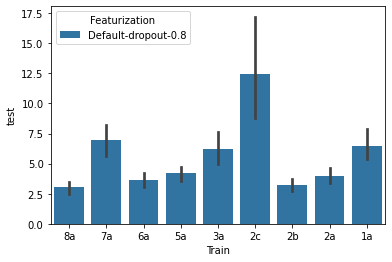

In [238]:
sns.barplot(data=rdf2, x="Train", y="test", hue="Featurization")